In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [15]:
grid = np.load('./np_map.npy')

In [16]:
max_tti = 500
def initialize_grid(ignite_cell, shape=(15,26)):
    start_x, start_y = ignite_cell
    grid = np.zeros(shape)
    # not-burning-0, burning-1, burnt-2, protected-3, barrier-4 for future implementation
    tti = np.random.randint(1, max_tti, size=shape)
    grid[start_x][start_y] = 1 # set start point on fire
    return grid, tti

def is_valid(grid, coordinates):
    x, y = coordinates[0], coordinates[1]
    if x < 0 or x >= grid.shape[0] or y < 0 or y >= grid.shape[1]:
        return False
    return True

def neighbour_factor(grid, coordinates):
    x, y = coordinates[0], coordinates[1]
    nearest_active = 0
    farther_active = 0
    for i in range(-2, 3):
        for j in range(-2, 3):
            if is_valid(grid, (x+i, y+j)) and grid[x+i][y+j] == 1:
                if abs(i) < 2 and abs(j) < 2: nearest_active += 1
                else: farther_active += 1
    return (nearest_active, farther_active)

def spread_probability(grid, coordinates, tti, neighbour_factors, alpha=1, beta=0.5):
    '''
    Calculates the probability of the given cell catching fire
    alpha: hyperparameter for final scaling
    beta: hyperparameter, weight for farther active cells
    equation => p = 1 - e^(-alpha*(1 + near + beta*far)*tti)
    '''
    x, y = coordinates
    near, far = neighbour_factors
    # standardize and scale the near and far neighbours
    near = near/8
    far = beta*(far/16)
    tti_val = tti[x][y]/max_tti
    prob = 1 - np.exp(-alpha*(1 + near + far)*tti_val)
    return prob

In [17]:
def update_grid(grid, tti, alpha=1, beta=0.5, gamma=0.1, warn_threshhold=0.9):
    updated = grid.copy()
    rows, cols = grid.shape
    for i in range(rows):
        for j in range(cols):
            if grid[i][j] == 1:
                for dx in range(-1, 2):
                    for dy in range(-1, 2):
                        child_x, child_y = i+dx, j+dy
                        if is_valid(grid, (child_x, child_y)) and grid[child_x][child_y] == 0:
                            neighbour_factors = neighbour_factor(grid, (child_x, child_y))
                            prob = spread_probability(grid, (child_x, child_y), tti, neighbour_factors, alpha, beta)
                            if random.random() < gamma*prob:
                                updated[child_x][child_y] = 1
                            elif prob>warn_threshhold:
                                updated[child_x][child_y] = 2

    return updated

In [18]:
def visualize_grid(grid, step):
    """ Visualize the grid using Matplotlib. """
    plt.imshow(grid, cmap='viridis', interpolation='nearest', vmin=0, vmax=2)
    plt.title(f'Cellular Growth Simulation - Step {step}')
    plt.colorbar()
    plt.pause(0.1)

def simulate_fire(ignite_cell, shape, alpha=1, beta=0.5, gamma=0.1, steps=50, warn_threshhold=0.9):
    ret = []
    grid, tti = initialize_grid(ignite_cell, shape=shape)
    visualize_grid(grid, 0)
    for step in range(1, steps):
        grid = update_grid(grid, tti, alpha, beta, gamma, warn_threshhold)
        # visualize_grid(grid, step)
        ret.append(grid.copy())
    return ret

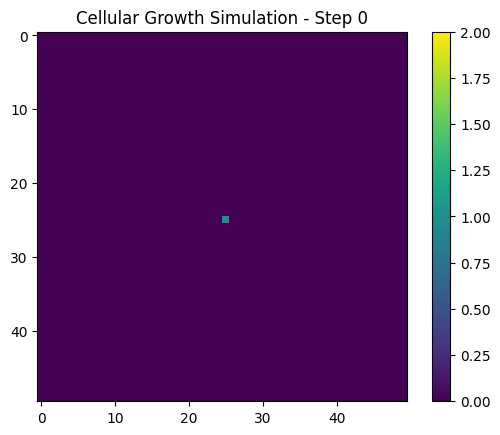

In [19]:
width, height = 50, 50
num_steps = 50

final = simulate_fire(ignite_cell=(25,25),shape=(width, height), gamma=0.5, steps=num_steps, warn_threshhold=0.8)
final = np.array(final)
import json
with open('simualate.json', 'w') as f:
    json.dump(final.tolist(), f)